Main Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None

Extra Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB
None

Main Data Sample:
   InstanceID  patientI

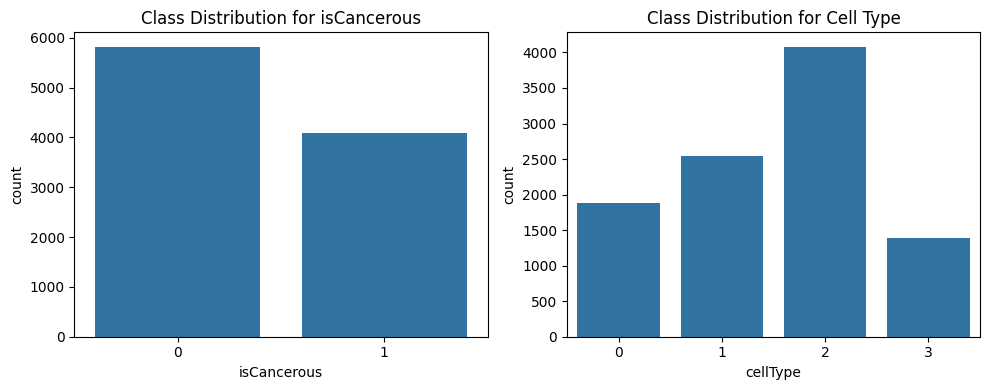


--- Checking for Missing Values ---
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

--- Summary Statistics for Main Data ---
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000     1.000000     0.000000
50%     9279.500000    26.000000     2.000000     0.000000
75%    16821.250000    47.000000     2.000000     1.000000
max    22444.000000    60.000000     3.000000     1.000000
Displaying sample images from the dataset:


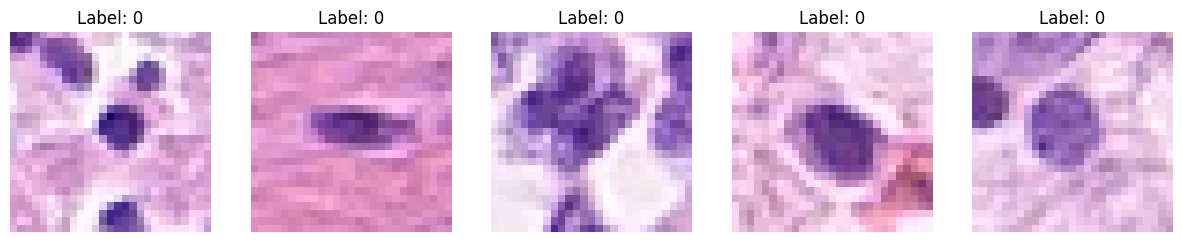

isCancerous
0    0.587813
1    0.412187
Name: proportion, dtype: float64
cellType
2    0.412187
1    0.256973
0    0.190784
3    0.140057
Name: proportion, dtype: float64


In [6]:
""# Colon Cancer Image Classification Project
# Step 1: Data Loading and Exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Paths to CSV files and Image folder
MAIN_DATA_CSV = 'data_labels_mainData.csv'
EXTRA_DATA_CSV = 'data_labels_extraData.csv'
IMAGE_FOLDER = 'patch_images/'

# Load CSV data
main_data = pd.read_csv(MAIN_DATA_CSV)
extra_data = pd.read_csv(EXTRA_DATA_CSV)

# Display basic info
print('Main Data Information:')
print(main_data.info())
print('\nExtra Data Information:')
print(extra_data.info())

# Display first few rows
print('\nMain Data Sample:')
print(main_data.head())
print('\nExtra Data Sample:')
print(extra_data.head())

# Check class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='isCancerous', data=main_data)
plt.title('Class Distribution for isCancerous')
plt.subplot(1, 2, 2)
sns.countplot(x='cellType', data=main_data)
plt.title('Class Distribution for Cell Type')
plt.tight_layout()
plt.show()

# Function to load and display a few images
def display_sample_images(df, image_folder, num_samples=5):
    samples = df.sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, row in enumerate(samples.iterrows()):
        img_path = os.path.join(image_folder, row[1]['ImageName'])
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img)
        plt.title(f"Label: {row[1]['isCancerous']}")
        plt.axis('off')
    plt.show()

# Checking for Missing Values
print("\n--- Checking for Missing Values ---")
print(main_data.isnull().sum())

# Summary Statistics for Main Data
print("\n--- Summary Statistics for Main Data ---")
print(main_data.describe())


# Display some sample images
print("Displaying sample images from the dataset:")
display_sample_images(main_data, IMAGE_FOLDER)
# Checking class balance
print(main_data['isCancerous'].value_counts(normalize=True))
print(main_data['cellType'].value_counts(normalize=True))



There is an imbalance between non cancerous (58.78 %) in comparison to cancerous (41.22%), meaning the modelk may be bias towards non cancerous. 

This means careful metric selection and data balancing is needed to ensure cancerous cases aren't overlooked

The cellType shows a clear imbalance across its four categories. Type 2 is the most prevalent (41.22%), while Type 3 is the least represented (14.01%). This imbalance could bias the model to perform better on Type 2 cells while misclassifying less represented types, such as Type 3. To mitigate this, class balancing strategies such as augmentation or class-weight adjustments will be considered during model training.

additionally from the sample images, blur looks like a potential issue

In [7]:
from sklearn.model_selection import train_test_split

patient_ids = main_data['patientID'].unique()


train_x, temp_x = train_test_split(patient_ids, test_size=0.3, random_state=42)


val_x, test_x = train_test_split(temp_x, test_size=0.5, random_state=42)

train_Data = main_data[main_data['patientID'].isin(train_x)]
val_Data = main_data[main_data['patientID'].isin(val_x)]
test_Data = main_data[main_data['patientID'].isin(test_x)]

print(f"Train: {len(train_Data)}, Val: {len(val_Data)}, Test: {len(test_Data)}")

train_patients_set = set(train_x)
val_patients_set = set(val_x)
test_patients_set = set(test_x)

overlap_train_val = train_patients_set.intersection(val_patients_set)
overlap_train_test = train_patients_set.intersection(test_patients_set)
overlap_val_test = val_patients_set.intersection(test_patients_set)

print(f"Train-Val Overlap: {overlap_train_val}")
print(f"Train-Test Overlap: {overlap_train_test}")
print(f"Val-Test Overlap: {overlap_val_test}")


Train: 6778, Val: 1257, Test: 1861
Train-Val Overlap: set()
Train-Test Overlap: set()
Val-Test Overlap: set()


6778 + 1257 + 1861 = 9896, which matches with amount of patients count from earlier. Meaning there should be no overlap but I did additionally make a method to ensure there is no overlap

F1-score will be used as the primary evaluation metric because it balances precision and recall, making it more suitable for imbalanced datasets where accuracy can be misleading.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# train_Data = train_Data.copy()
# val_Data = val_Data.copy()
# test_Data = test_Data.copy()

# train_Data.loc[:, 'isCancerous_str'] = train_Data['isCancerous'].astype(str)
# val_Data.loc[:, 'isCancerous_str'] = val_Data['isCancerous'].astype(str)
# test_Data.loc[:, 'isCancerous_str'] = test_Data['isCancerous'].astype(str)

# train_Datagen = ImageDataGenerator(
#     rescale=1./255
# )

# val_test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_Datagen.flow_from_dataframe(
#     train_Data,
#     directory=IMAGE_FOLDER,
#     x_col='ImageName',
#     y_col='isCancerous_str',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# val_generator = val_test_datagen.flow_from_dataframe(
#     val_Data,
#     directory=IMAGE_FOLDER,
#     x_col='ImageName',
#     y_col='isCancerous_str',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# test_generator = val_test_datagen.flow_from_dataframe(
#     test_Data,
#     directory=IMAGE_FOLDER,
#     x_col='ImageName',
#     y_col='isCancerous_str',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False
# )
# #checking to see if tensor detects my gpu 
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# from tensorflow.keras import layers, models
# #since this is binary, lamda iun't needed yet
# def create_cnn_model():
#     model = models.Sequential([
#         layers.Input(shape=(224, 224, 3)),
#         layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     return model

# def create_mlp_model():
#     model = models.Sequential([
#         layers.Input(shape=(224, 224, 3)),
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     return model

# from tensorflow.keras import optimizers
# from tensorflow.keras.callbacks import EarlyStopping

# cnn_model = create_cnn_model()
# cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])


# mlp_model = create_mlp_model()
# mlp_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

# early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# history_cnn = cnn_model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=30,
#     callbacks=[early_stop]
# )

# history_mlp = mlp_model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=30,
#     callbacks=[early_stop]
# )

# def plot_learning_curves(history, model_name):
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Val Loss')
#     plt.title(f'{model_name} Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#     plt.title(f'{model_name} Accuracy')
#     plt.legend()
#     plt.show()

# plot_learning_curves(history_cnn, 'CNN')

# plot_learning_curves(history_mlp, 'MLP')

# from sklearn.metrics import f1_score, classification_report

# test_preds_cnn = cnn_model.predict(test_generator)
# test_preds_cnn_labels = (test_preds_cnn > 0.5).astype(int)

# test_preds_mlp = mlp_model.predict(test_generator)
# test_preds_mlp_labels = (test_preds_mlp > 0.5).astype(int)

# true_labels = test_generator.classes

# f1_cnn = f1_score(true_labels, test_preds_cnn_labels)
# f1_mlp = f1_score(true_labels, test_preds_mlp_labels)

# print(f'CNN Test F1-Score: {f1_cnn:.4f}')
# print(f'MLP Test F1-Score: {f1_mlp:.4f}')


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_Data = train_Data.copy()
val_Data = val_Data.copy()
test_Data = test_Data.copy()

train_Data['cellType_str'] = train_Data['cellType'].astype(str)
val_Data['cellType_str'] = val_Data['cellType'].astype(str)
test_Data['cellType_str'] = test_Data['cellType'].astype(str)

train_generator_ct = train_Datagen.flow_from_dataframe(
    train_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='cellType_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator_ct = val_test_datagen.flow_from_dataframe(
    val_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='cellType_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator_ct = val_test_datagen.flow_from_dataframe(
    test_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='cellType_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


def create_cnn_model_multiclass():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])
    return model

"""def create_mlp_model_multiclass():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])
    return model"""

from tensorflow.keras.losses import CategoricalCrossentropy

cnn_model_ct = create_cnn_model_multiclass()
cnn_model_ct.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss=CategoricalCrossentropy(),
                    metrics=['categorical_accuracy'])

"""mlp_model_ct = create_mlp_model_multiclass()
mlp_model_ct.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss=CategoricalCrossentropy(),
                    metrics=['categorical_accuracy'])"""

# Train with EarlyStopping
history_cnn_ct = cnn_model_ct.fit(
    train_generator_ct,
    validation_data=val_generator_ct,
    epochs=30,
    callbacks=[early_stop]
)

"""history_mlp_ct = mlp_model_ct.fit(
    train_generator_ct,
    validation_data=val_generator_ct,
    epochs=30,
    callbacks=[early_stop]
)"""

from sklearn.metrics import f1_score

# Predict CNN
cnn_preds_ct = cnn_model_ct.predict(test_generator_ct)
cnn_preds_ct_labels = cnn_preds_ct.argmax(axis=1)

# Predict MLP
##mlp_preds_ct = mlp_model_ct.predict(test_generator_ct)
##mlp_preds_ct_labels = mlp_preds_ct.argmax(axis=1)

# True labels
true_labels_ct = test_generator_ct.classes

# F1 Scores
f1_cnn_ct = f1_score(true_labels_ct, cnn_preds_ct_labels, average='weighted')
##f1_mlp_ct = f1_score(true_labels_ct, mlp_preds_ct_labels, average='weighted')

print(f'CNN cellType F1-Score: {f1_cnn_ct:.4f}')
##print(f'MLP cellType F1-Score: {f1_mlp_ct:.4f}')

Found 6778 validated image filenames belonging to 4 classes.
Found 1257 validated image filenames belonging to 4 classes.
Found 1861 validated image filenames belonging to 4 classes.
Epoch 1/30


c:\Users\micro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 93s 435ms/step - categorical_accuracy: 0.4828 - loss: 2.2952 - val_categorical_accuracy: 0.6531 - val_loss: 0.8827
Epoch 2/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 92s 436ms/step - categorical_accuracy: 0.6869 - loss: 0.8032 - val_categorical_accuracy: 0.6340 - val_loss: 0.8557
Epoch 3/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 92s 432ms/step - categorical_accuracy: 0.7074 - loss: 0.7354 - val_categorical_accuracy: 0.6595 - val_loss: 0.8237
Epoch 4/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 92s 432ms/step - categorical_accuracy: 0.7172 - loss: 0.6923 - val_categorical_accuracy: 0.6492 - val_loss: 0.8252
Epoch 5/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 105s 494ms/step - categorical_accuracy: 0.7510 - loss: 0.6340 - val_categorical_accuracy: 0.6818 - val_loss: 0.8135
Epoch 6/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 108s 509ms/step - categorical_accuracy: 0.7765 - loss: 0.5752 - val_categorical_accuracy: 0.6762 - val_loss: 0.8920
Epoch 7/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 106s 500ms/step - categorical_accuracy:

**Prevention of Data Leakages**

As with all things involving the medical field, avoiding patient-based data leakage is paramount. There’s serious risks that a model trained on data from outside the training set, will respond poorly on future data. For example if the model is performing impressively during training and validation, but when testing it on real world data it entirely misses targets and has poor accuracy. 

One method to reduce data leakage without risking a loss of confidentiality would be to use some kind of encryption for patient data. In this way, a patient’s ID can be attached to data even within databases, without a risk of losing confidentiality. If a patient’s ID was encrypted, then you could compare the encrypted strings in order to ensure that no data is being leaked between sets, whilst also maintaining the confidentiality of the patient’s sensitive information. 

Another method to reduce data leakage would be to introduce heavy auditing of data. If a model is showing unexpected patterns in prediction, or looks to be performing in an atypical way for the data it's being trained on, it could use a deeper investigation in order to maintain its accuracy and its scope towards only the expected train data. If the model starts to show worse signs of performance as its being introduced to new data, it gives a strong correlation that earlier training and metrics that were used on the model could have data leakage within them. 


In [ ]:
# OVERFITTING/UNDERFITTING DETECTION    (1.4)
# ADD VISUAL TOOLS (learning curves?) to explain model fitting status, 0.5 marks per method
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#THIS LINE, split for train (X) and target (y)
X, y = train_Data["isCancerous"], train_Data["Count"]

train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(),
                                                        X, y, cv = 10, scoring = "accuracy", n_jobs = -1,
                                                        train_sizes = np.linspace(0.01, 1.0, 50)
                                                        )

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)

test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.subplots(1, figsize = (10, 10))
plt.plot(train_sizes, train_mean, '--', color = "blue", label = "Training Scores")
plt.plot(train_sizes, test_mean, color = "red", label = "Cross-Validation Scores")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "red")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "blue")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc = "best")
plt.tight_layout()
plt.show()

KeyError: 'Count'

**Optimisation Techniques**

Dropout is a technique where a random set of neurons within the network are dropped (or zeroed out) during an iteration. The reason for doing this is that it allows the network to not rely just on a few specific nodes, instead favouring a use of varied nodes which can learn more generally. This is a technique which can help a model perform better on newer data, as the more generally the model learns, the more likely it can adapt to newer data.

Regularisation is a technique where a penalty is added to a loss function and incorporated into the model, in order to prevent the model from overfitting and dissuade it from learning patterns too heavily related to the training dataset. It once again helps a model perform better on newer data, as the less overfitted a model, the more likely it will perform well on a more general set of data.

**Validation Set Use**

A validation set is another way to reduce overfitting, and also underfitting. By having a validation set, once the model has been trained on the train set it can then be compared against the validation set in order to see any strange patterns (such as overfitting or underfitting), as it exists as its own separate dataset you can see a direct correlation between how the model handles unseen data. The validation set can also be used to tune characteristics and find the most accurate model and configurations if there's several models being considered (such as in our assignment). By using a validation set the hyperparameters within the model can be tuned and the model's peak performance can be achieved without overfitting to the train set.

In [ ]:
# FINAL MODEL ACCURACY  (1.5)
# ADD CODE / need to show improved accuracy and provide justifications (e.g. deeper layers, model switch...)

**Generalisability**

One way robustness of the model was ensured with the separation and use of both train datasets as well as validation datasets. This allows an accurate level of assurance that there's no overfitting withing the data. Another way robustness was ensured was through the use of a CNN model. When it comes to image recongition, one of the strongest model types is a CNN model, as it doesn't require human supervision to run. It can achieve automatic feature extraction on its own across a vast dataset, which allows it to maintain robustness even across a large size of images.

Generalisability of the model was ensured further by the use of these validation datasets. Validation datasets help to make a model more general and less tuned or fitted to the train data alone. Another key feature was augmentation, which regularises the datasets further by adding more variability or noise to the training datasets. By adding augmentation the model will learn a more generalised approach to the concepts in the data rather than just learning to memorise the training data itself. This allows the model to have a higher accuracy and higher chance of correct predictions within further unseen data, ensuring generalisability.

# **SECTION 2**
2.1

**Comparative Analysis**

##TO ADD

Compare both labels (cellType/ isCancerous) with baseline and with an academic reference

**Fairness and Consistency**

#TO ADD

Discuss if comparison was valid or limited due to differing metrics.

#TO ADD

Clearly compare baseline vs secondary method for both cellType and isCancerous, considering the fairness of the justification...

**Semi-Supervised Learning**

Semi-Supervised Learning is the combination of both Supervised Learning, and Unsupervised Learning on a model. Because Unsupervised Learning is a model that is trained using unlabelled data, Semi-Supervised Learning is therefore the building of a model in which labelled and unlabelled data are both used in order to teach the model.

#TO ADD 

EXPLANATION HOW IT APPLIES TO THIS PROJECT USING EXTRA DATA

#TO ADD

REFLECT ON STRENGTHS AND WEAKNESSES

**Real-world Applicability of Semi-Supervised Learning**

Semi-Supervised Learning is best used in a real world scenario which involved data which is difficult to add labels to, such as handling images or sounds. As such a real world scenario could be a voice-to-text application, where you speak your voice into the microphone and the application relays to you the words you spoke. By making use of the abundance of unlabelled sounds that exist, and the smaller amount of labelled sounds, a model built using SSL could easily become very accurate. Because SSL uses both labelled and unlabelled data, it can boost the task performance of a model built using it by allowing the model to extract more information from the two data types, which can give a higher accuracy or a more robust set of predictions. It allows more flexibility and a better cost optimisation over using either set of the strictly one type of learning models.

# **Appendix**